# Topic Estimation Steps:


1. Text preprocessing and tokenization

2. Train topic estimation model
    - Make document-term matrix
        - input: tokens 
        - tool: CountVectorizer
    - Make topic distribution matrix
        - input:
            i) document-term matrix -> term-document matrix -> corpus
            ii) dictionary (from gensim, Not pandas dict)
        - tool: Latent Dirichlet Allocation
    - Evaluate coherence
3. Visualization model
    - tool: pyLDAvis
    - also, each piece of text is expressed in terms of a list of topics, and the probability for each topic


# Import libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from gensim import matutils, models
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models


In [38]:
# in order to use NLTK's lemmatizer, need to download library

import nltk
# nltk.download('wordnet')

# to see where it is downloaded to
print(nltk.find('corpora/wordnet.zip'))

/Users/carmen/nltk_data/corpora/wordnet.zip


# Text to be grouped into different topics

In [39]:
pd.set_option('display.max_colwidth', None)

In [40]:
df = pd.read_excel('../data/drug_names_kaggle_TASK.xlsx',
                  header = 1,
                  usecols = [1])

In [41]:
df.head(2)

,Introduction
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding."
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding."


# Topic Estimation

## 1. Text preprocessing and tokenization

In [42]:
def tokenize(text):
    
    list_str_exclude = ['mg', 'ml', 'gm', 'iu', 'mcg']
    # need to add words to this list manually
    
    tokenizer = RegexpTokenizer(r'\w+')
    text = text.lower()
#     print(text)
    tokenized_text = tokenizer.tokenize(text)
#     print(tokenized_text)

    # Remove numbers, but not words that contain numbers.
    tokenized_text = [token for token in tokenized_text if not token.isnumeric()]

    # Remove words that are only one character.
    tokenized_text = [token for token in tokenized_text if len(token) > 1]
    
    # Remove words that are dosage
    tokenized_text = [token for token in tokenized_text if not any(unimportant in token for unimportant in list_str_exclude)]
    
    return tokenized_text

In [43]:
def lemmatize_tokens(tokens):
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [44]:
df['tokens'] = df['Introduction'].apply(lambda x: lemmatize_tokens(tokenize(x)))

In [45]:
df.head(2)

,Introduction,tokens
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]"
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]"


## 2. Train topic estimation model

In [46]:
def create_corpus_dictonary(text_data, max_term_freq, min_term_count):

    def identity_tokenizer(text):
        return text
    
    # create document-term matrix
    count_vectorizer = CountVectorizer(tokenizer = identity_tokenizer,
                                      lowercase = False,
                                      max_df = max_term_freq, # ignoring terms that have a document frequency > x% of the number of document (by percentage)
                                      min_df = min_term_count) # ignoring terms that have a document frequency < x (count) 

    count_matrix = count_vectorizer.fit_transform(text_data)
    print('count_matrix.shape: ', count_matrix.shape)
    
    # create dictionary of index: term
    dictionary = count_vectorizer.get_feature_names_out()
    print('length of dictionary: ', len(dictionary))
    id2word = {v: k for v, k in enumerate(dictionary)}    
    # for coherence evaluation, create dictionary of term: index
    word2id = dict((k, v) for k, v in count_vectorizer.vocabulary_.items())

    d = corpora.Dictionary()
    d.id2token = id2word
    d.token2id = word2id

    
    # create term-document matrix
    count_matrix_T = count_matrix.transpose()
    # convert from sparse to proper format for LDA
    corpus = matutils.Sparse2Corpus(count_matrix_T)
    
    return corpus, d, id2word, word2id


In [47]:
def train_model_get_coherence_score(corpus, id2word, topic_count, word2id):
    
    passes = 10
    iterations = 50 # 50 is the default
    
    lda = models.LdaModel(corpus = corpus,
                          id2word = id2word,
                          num_topics = topic_count,
                          passes = passes,
                          iterations = iterations)
    
    # evaluation coherence
    coherence_model_lda = CoherenceModel(model = lda, 
                                         corpus = corpus, 
                                         dictionary = word2id, 
                                         coherence = 'u_mass'
                                        )
    coherence_lda = coherence_model_lda.get_coherence()
    
    return lda, coherence_lda
    

### fix max_term_freq and min_term_freq, vary topic_count

In [149]:
starttime = time.time()

max_term_freq = 0.7
min_term_count = 1

Corpus, D, Id2word, Word2id = create_corpus_dictonary(df['tokens'], max_term_freq, min_term_count)
print('max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

elapsedtime = time.time() - starttime
print('time taken to calculate: {}'.format(elapsedtime))

count_matrix.shape:  (1000, 2710)
length of dictionary:  2710
max_term_freq = 0.7, min_term_count = 1
time taken to calculate: 0.09284687042236328


/Users/carmen/anaconda3/envs/streamlit_conda391/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [150]:
dict_coherence_score_topic_count = {}
for i in range(3, 10):
    Lda, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, i, Word2id)
    dict_coherence_score_topic_count[i] = Coherence_score

In [151]:
dict_coherence_score_topic_count = dict(sorted(dict_coherence_score_topic_count.items()))

Text(0.5, 1.0, 'Max_term_freq = 0.7, min_term_count = 1')

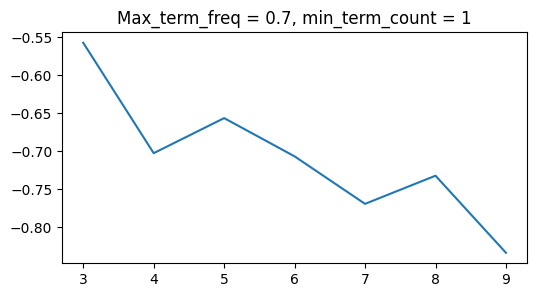

In [152]:
plt.figure(figsize = (6,3))
plt.plot(dict_coherence_score_topic_count.keys(),
        dict_coherence_score_topic_count.values())
plt.title('Max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

# Visualize model

## pyLDAvis

In [153]:
pyLDAvis.enable_notebook()

In [204]:
Lda5, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 5, Word2id)

In [205]:
vis5 = pyLDAvis.gensim_models.prepare(Lda5, Corpus, D, sort_topics = False)
vis5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.132932  0.041295       1        1  22.749893
1     -0.203541 -0.017664       2        1  15.662585
2      0.068483 -0.168886       3        1  16.823059
3      0.041635  0.101302       4        1  29.600889
4     -0.039509  0.043953       5        1  15.163574, topic_info=          Term         Freq        Total Category  logprob  loglift
411   pressure   750.000000   750.000000  Default  30.0000  30.0000
410      blood  1625.000000  1625.000000  Default  29.0000  29.0000
670      level   809.000000   809.000000  Default  28.0000  28.0000
162  infection   643.000000   643.000000  Default  27.0000  27.0000
159       type   417.000000   417.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
70        some   142.595238   842.912040   Topic5  -4.8702   0.1094
131       most   125.069845   851.833182   Topic5  -5.0013  -0.0322
20       these   128.175877  1019.332645   Topic5  -4.9768  -0.1872
159       type   110.758509   417.559460   Topic5  -5.1229   0.5592
112       food   118.121480   737.132828   Topic5  -5.0585   0.0552

[407 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
93        1  0.703983      about
93        2  0.002159      about
93        3  0.088538      about
93        4  0.069103      about
93        5  0.136046      about
...     ...       ...        ...
238       1  0.008175  worsening
238       2  0.686673  worsening
238       3  0.065397  worsening
238       4  0.228891  worsening
238       5  0.008175  worsening

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [156]:
Lda4, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 4, Word2id)

In [157]:
print('This model has coherence score = {}'.format(Coherence_score))

This model has coherence score = -0.6795541212951337


In [158]:
vis4 = pyLDAvis.gensim_models.prepare(Lda4, Corpus, D, sort_topics = False)
vis4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.153323  0.062065       1        1  27.467239
1     -0.129268  0.079819       2        1  23.215492
2      0.011965 -0.089790       3        1  22.298178
3     -0.036020 -0.052094       4        1  27.019090, topic_info=           Term         Freq        Total Category  logprob  loglift
410       blood  1615.000000  1615.000000  Default  30.0000  30.0000
411    pressure   744.000000   744.000000  Default  29.0000  29.0000
162   infection   644.000000   644.000000  Default  28.0000  28.0000
159        type   420.000000   420.000000  Default  27.0000  27.0000
323  medication   550.000000   550.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
4          that   246.686825  1036.514008   Topic4  -4.8997  -0.1269
55        using   196.274689   575.713346   Topic4  -5.1283   0.2325
123        will   208.891518   816.718031   Topic4  -5.0660  -0.0549
142       while   201.431090   704.509780   Topic4  -5.1024   0.0566
13           on   206.749315   965.160420   Topic4  -5.0763  -0.2322

[358 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
365       1  0.040341    able
365       2  0.020171    able
365       3  0.040341    able
365       4  0.927847    able
93        1  0.633102   about
...     ...       ...     ...
17        4  0.298042    work
198       1  0.822596  worsen
198       2  0.010637  worsen
198       3  0.106370  worsen
198       4  0.060276  worsen

[747 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

# Save model
- best coherence score (and visually best separations) with LDA model with 4 topics
- to show on streamlit
    - good instr: https://medium.com/@lelwonger/incorporating-functions-with-html-output-in-streamlit-pyldavis-lime-25b13717d913
    

In [264]:
Lda4.save('../models/lda4.model')

In [265]:
# for visualization
pyLDAvis.save_html(vis4, '../models/vis4.html')

In [266]:
tempfile4 = datapath('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4.model')

In [267]:
Lda4.save(tempfile4)

In [268]:
# save Corpus as well
corpora.MmCorpus.serialize('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_corpus', Corpus)

In [216]:
# corpora.Dictionary.save('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_dictionary')

In [269]:
Lda5.save('../models/lda5.model')

# for visualization
pyLDAvis.save_html(vis5, '../models/vis5.html')
tempfile5 = datapath('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5.model')
Lda5.save(tempfile5)
# save Corpus as well
corpora.MmCorpus.serialize('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5_corpus', Corpus)

# Check how to use model

## from model, get topic-term matrix

In [218]:
lda_fromload = models.LdaModel.load(tempfile5)

In [219]:
lda_fromload

In [220]:
# topics-term matrix
#https://stackoverflow.com/questions/47424335/access-term-topic-matrix-generated-by-gensim-lda

df_topic_term_matrix = pd.DataFrame(lda_fromload.get_topics(), 
                                     columns = lda_fromload.id2word.values(), 
                                     index=[f'topic {i}' for i in range(lda_fromload.num_topics)])

In [221]:
df_topic_term_matrix

2        3d        3l        6l        ab       abd   abdomen  \
topic 0  0.000076  0.000007  0.000007  0.000007  0.000489  0.000007  0.000351   
topic 1  0.000010  0.000010  0.000010  0.000010  0.000010  0.000010  0.000262   
topic 2  0.000009  0.000149  0.000010  0.000010  0.000010  0.000067  0.000103   
topic 3  0.000006  0.000060  0.000006  0.000006  0.000006  0.000026  0.000006   
topic 4  0.000011  0.000011  0.000169  0.000169  0.000013  0.000116  0.000015   

         abdominal      abel  abhayrab   ability  abirapro   abiways  \
topic 0   0.001025  0.000007  0.000007  0.000268  0.000008  0.000076   
topic 1   0.001802  0.000011  0.000111  0.000265  0.000010  0.000010   
topic 2   0.000079  0.000009  0.000009  0.000392  0.000010  0.000009   
topic 3   0.000810  0.000113  0.000006  0.001150  0.000057  0.000006   
topic 4   0.000036  0.000013  0.000011  0.000035  0.000015  0.000011   

           abixim      able  abnormal  abnormality   abortab  abortion  \
topic 0  0.000007  0.000965  0.000012     0.000089  0.000076  0.000490   
topic 1  0.000010  0.000013  0.000121     0.000011  0.000010  0.000010   
topic 2  0.000009  0.000124  0.000076     0.000202  0.000010  0.000010   
topic 3  0.000006  0.000407  0.000686     0.000036  0.000006  0.000006   
topic 4  0.000116  0.000286  0.000033     0.000030  0.000011  0.000011   

            about     above  abruptly    absorb  absorbed  absorption  \
topic 0  0.011679  0.000173  0.000008  0.000007  0.000007    0.000007   
topic 1  0.000055  0.000011  0.000011  0.000010  0.000212    0.000010   
topic 2  0.001996  0.000033  0.000128  0.000010  0.000010    0.000009   
topic 3  0.000895  0.000270  0.000208  0.000006  0.000006    0.000008   
topic 4  0.003376  0.000011  0.000012  0.000116  0.000011    0.000165   

         abstinence  abundant     abuse       abz    abzorb  acamprol  \
topic 0    0.000008  0.000035  0.000007  0.000007  0.000007  0.000007   
topic 1    0.000010  0.000010  0.000010  0.000010  0.000049  0.000010   
topic 2    0.000011  0.000009  0.000009  0.000009  0.000066  0.000009   
topic 3    0.000086  0.000010  0.000060  0.000005  0.000006  0.000060   
topic 4    0.000011  0.000011  0.000011  0.000116  0.000011  0.000011   

         acamptas  acceclowoc  accentrix  accident  accidental  accidentally  \
topic 0  0.000007    0.000007   0.000007  0.000008    0.000007      0.000007   
topic 1  0.000010    0.000010   0.000010  0.000011    0.000011      0.000010   
topic 2  0.000009    0.000120   0.000103  0.000470    0.000845      0.000568   
topic 3  0.000060    0.000005   0.000005  0.000005    0.000006      0.000006   
topic 4  0.000011    0.000150   0.000011  0.000017    0.000018      0.000013   

         according  accurate       ace    aceclo  aceclobest  aceclomax  \
topic 0   0.000008  0.000007  0.000205  0.000147    0.000007   0.000007   
topic 1   0.000012  0.000010  0.000010  0.000010    0.000010   0.000010   
topic 2   0.000011  0.000055  0.000148  0.000385    0.000149   0.000009   
topic 3   0.000008  0.000006  0.000061  0.000006    0.000006   0.000006   
topic 4   0.003127  0.000011  0.000026  0.000165    0.000011   0.000116   

         acecloren  aceclorite   aceflam  aceloflam    acemiz  acemyoset  \
topic 0   0.000007    0.000007  0.000007   0.000007  0.000077   0.000007   
topic 1   0.000010    0.000010  0.000010   0.000010  0.000010   0.000010   
topic 2   0.000149    0.000009  0.000009   0.000149  0.000380   0.000010   
topic 3   0.000006    0.000006  0.000006   0.000006  0.000006   0.000006   
topic 4   0.000011    0.000116  0.000116   0.000011  0.000172   0.000116   

           acenac    acenal   acenext    acepar     acera    aceret    aceron  \
topic 0  0.000076  0.000007  0.000007  0.000007  0.000144  0.000108  0.000036   
topic 1  0.000010  0.000010  0.000010  0.000010  0.000010  0.000010  0.000010   
topic 2  0.000389  0.000149  0.000009  0.000009  0.000009  0.000010  0.000010   
topic 3  0.000006  0.000006  0.000005  0.000006  0.000006  0

In [223]:
pd.set_option('display.max_columns', None)
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:80]

dose           0.017567
symptom        0.015743
know           0.014964
these          0.013954
can            0.013899
                 ...   
need           0.003747
focus          0.003721
such           0.003673
work           0.003633
combination    0.003632
Name: topic 0, Length: 80, dtype: float32

## from model, get topic probabilities for each entry

In [224]:
df.iloc[1]['Introduction']

"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day.\xa0 The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms.\xa0 It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may 

In [225]:
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:50]

dose          0.017567
symptom       0.015743
know          0.014964
these         0.013954
can           0.013899
most          0.013737
all           0.012068
how           0.012002
about         0.011679
condition     0.011082
medication    0.011082
tell          0.010417
on            0.010285
while         0.009367
let           0.009322
take          0.009239
affect        0.009152
that          0.008993
so            0.008649
food          0.008032
tablet        0.007898
will          0.007723
advised       0.007470
cause         0.007248
avoid         0.006984
some          0.006770
liver         0.006746
sleepiness    0.006700
make          0.006524
alcohol       0.006477
kidney        0.006441
stomach       0.006439
nose          0.006332
stop          0.006279
away          0.006180
worsen        0.006179
disease       0.006141
without       0.006092
long          0.005889
headache      0.005846
usually       0.005639
keep          0.005476
pain          0.005462
nausea     

In [226]:
len(Corpus)

1000

In [227]:
lda_corpus = corpora.MmCorpus('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5_corpus')

In [228]:
len(lda_corpus)

1000

In [229]:
def get_medication_name(text):
    
    first_sentence = text.partition('.')[0]
    name = ' '.join(re.findall(r'\b[A-Z][a-z]+|\b[A-Z]\b', first_sentence))
    
    return name

In [230]:
df['medication_name'] = df['Introduction'].apply(lambda x: get_medication_name(x))

In [231]:
df.head(2)

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]",Acnesol Gel,0.755798,0.0,0.239647,0.0,"[(0, 0.7557982), (2, 0.23964673)]"
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]",Ambrodil Syrup,0.350048,0.0,0.644214,0.

In [232]:
list_topic_estimation = []
for i in range(len(lda_corpus)):   
    topic_estimation = lda_fromload.get_document_topics(lda_corpus[i])
    list_topic_estimation.append(topic_estimation)

In [233]:
list_topic_estimation[:2]

[[(2, 0.99305695)], [(0, 0.9911691)]]

In [234]:
topic_count = 5
for i in range(topic_count):
    column_name = 'topic' + str(i)
    df[column_name] = 0.0

In [235]:
df['topic_estimation'] = list_topic_estimation

In [236]:
for i in range(len(df)):
# for i in range(2):
#     print('i: ', i)
    for j in df.iloc[i].loc['topic_estimation']:
#         print('j: ', j)
        for k in range(topic_count):
#             print('k: ', k)
            if k == j[0]:
                estimation = j[1]
#                 print('estimation: ', estimation)
                column_name = 'topic' + str(k)
#                 print('column_name: ', column_name)
                df.at[i, column_name] = estimation

In [241]:
df.head(2)

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]",Acnesol Gel,0.000000,0.0,0.993057,0.0,"[(2, 0.99305695)]",0.0
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]",Ambrodil Syrup,0.991169,0.0,0.000000,0.0,"[(

#  Check topics

(array([667.,  45.,  28.,  17.,   7.,  18.,  26.,  19.,  19., 154.]),
 array([0.        , 0.09942621, 0.19885242, 0.29827863, 0.39770484,
        0.49713105, 0.59655726, 0.69598347, 0.79540968, 0.89483589,
        0.9942621 ]),
 <BarContainer object of 10 artists>)

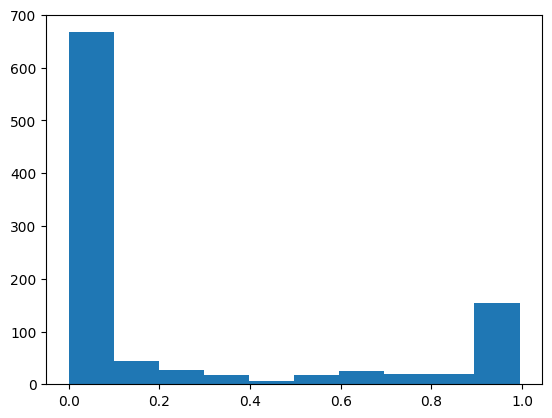

In [242]:
plt.hist(df.topic0)

In [243]:
df_topic0 = df[df.topic0 > 0.9]

In [244]:
df_topic0
# allergic symptoms involving the respiratory tract, also gastrointestinal tract symptoms

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, is, used, for, treating, various, respiratory, tract, disorder, associated, with, excessive, mucus, it, work, by, thinning, and, loosens, mucus, in, the, nose, windpipe, and, lung, and, make, it, easier, to, cough, out, ambrodil, syrup, should, be, taken, with, food, for, better, result, it, is, suggested, to, take, it, at, the, same, time, every, day, the, dose, and, how, often, you, take, it, depends, on, what, you, are, taking, it, for, your, doctor, will, decide, how, much, you, need, to, improve, your, symptom, it, is, advised, not, to, use, it, for, more, than, day, without, doctor, consultation, the, most, ...]",Ambrodil Syrup,0.991169,0.0,0.0,0.000000,"[(0, 0.9911691)]",0.000000
6,"Ascoril LS Syrup is a combination medicine used in the treatment of cough with mucus. It thins mucus in the nose, windpipe and lungs, making it easier to cough out. It also provides relief from runny nose, sneezing, itching, and watery eyes.Ascoril LS Syrup is taken with or without food in a dose and duration as advised by the doctor. The dose you are given will depend on your condition and how you respond to the medicine. You should keep taking this medicine for as long as your doctor recommends. If you stop treatment too early your symptoms may come back and your condition may worsen. Let your healthcare team know about all other medications you are taking as some may affect, or be affected by this medicine.The most common side effects are nausea, diarrhea, stomach pain, vomiting, muscle cramp, headache, skin rash, and increased heart rate. Most of these are temporary and usually resolve with time. Contact your doctor straight away if you are at all concerned about any of these side effects. This medicine can also cause sleepiness, so do not drive or do anything that requires mental focus until you know how this medicine affects you. Avoid drinking alcohol while taking this medicine as it can make sleepiness worse.Never support self-medication or recommend your medicine to another person. It is beneficial to have plenty of fluids while taking this medication. Before taking this medicine, you should tell your doctor if you are pregnant, planning pregnancy or breastfeeding. You should also tell your doctor if you have any kidney or liver diseases so that your doctor can prescribe a suitable dose for you.","[ascoril, l, syrup, is, combination, medicine, used, in, the, treatment, of, cough, with, mucus, it, thins, mucus, in, the, nose, windpipe, and, lung, making, it, easier, to, cough, out, it, also, provides, relief, from, runny, nose, sneezing, itching, and, watery, eye, ascoril, l, syrup, is, taken, with, or, without, food, in, dose, and, duration, a, advised, by, the, doctor, the, dose, you, are, given,

In [245]:
len(df_topic0)

153

(array([762.,  52.,  16.,  19.,  13.,  10.,  13.,   2.,   1., 112.]),
 array([0.        , 0.09949811, 0.19899622, 0.29849433, 0.39799244,
        0.49749056, 0.59698867, 0.69648678, 0.79598489, 0.895483  ,
        0.99498111]),
 <BarContainer object of 10 artists>)

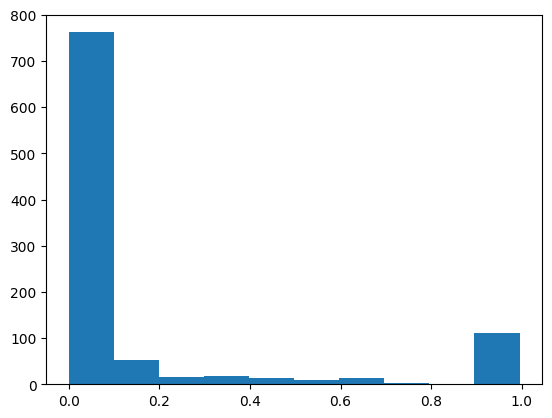

In [246]:
plt.hist(df.topic1)

In [247]:
df_topic1 = df[df.topic1 > 0.9]

In [248]:
df_topic1
# anti-bacterial and antibiotics for respiratory tract, blood cholesterol-lowering

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
3,"Azithral 500 Tablet is an antibiotic used to treat various types of bacterial infections of the respiratory tract, ear, nose, throat, lungs, skin, and eye in adults and children. It is also effective in typhoid fever and some sexually transmitted diseases like gonorrhea.Azithral 500 Tablet is a broad-spectrum type of antibiotic effective in killing many types of gram-positive bacteria, some types of gram-negative bacteria and other microorganisms. This medicine is taken orally, preferably either one hour before or 2 hours after a meal. It should be used regularly at evenly spaced time intervals as prescribed by your doctor. Do not skip any doses and finish the full course of treatment even if you feel better. Stopping the medicine too early may lead to the return or worsening of the infection.Commonly seen side effects seen with this medicine include vomiting, nausea, stomach pain, and diarrhea. These are usually temporary and subside with the completion of treatment. Consult your doctor if you find these side effects worry you or persist for a longer duration.Inform your doctor if you have any previous history of allergy or heart problems before taking this medicine. Pregnant or breastfeeding women should consult their doctor before using this medicine.","[azithral, tablet, is, an, antibiotic, used, to, treat, various, type, of, bacterial, infection, of, the, respiratory, tract, ear, nose, throat, lung, skin, and, eye, in, adult, and, child, it, is, also, effective, in, typhoid, fever, and, some, sexually, transmitted, disease, like, gonorrhea, azithral, tablet, is, broad, spectrum, type, of, antibiotic, effective, in, killing, many, type, of, gram, positive, bacteria, some, type, of, gram, negative, bacteria, and, other, microorganism, this, medicine, is, taken, orally, preferably, either, one, hour, before, or, hour, after, meal, it, should, be, used, regularly, at, evenly, spaced, time, interval, a, prescribed, by, your, doctor, do, not, skip, ...]",Azithral Tablet,0.0,0.992462,0.0,0.0,"[(1, 0.9924624)]",0.0
9,"Azee 500 Tablet is an antibiotic used to treat various types of bacterial infections of the respiratory tract, ear, nose, throat, lungs, skin, and eye in adults and children. It is also effective in typhoid fever and some sexually transmitted diseases like gonorrhea.Azee 500 Tablet is a broad-spectrum type of antibiotic effective in killing many types of gram-positive bacteria, some types of gram-negative bacteria and other microorganisms. This medicine is taken orally, preferably either one hour before or 2 hours after a meal. It should be used regularly at evenly spaced time intervals as prescribed by your doctor. Do not skip any doses and finish the full course of treatment even if you feel better. Stopping the medicine too early may lead to the return or worsening of the infection.Commonly seen side effects seen with this medicine include vomiting, nausea, stomach pain, and diarrhea. These are usually temporary and subside with the completion of treatment. Consult your doctor if you find these side effects worry you or persist for a longer duration.Inform your doctor if you have any previous history of allergy or heart problems before taking this medicine. Pregnant or breastfeeding women should consult their doctor before using this medicine.","[azee, tablet, is, an, antibiotic, used, to, treat, various, type, of, bacterial, infection, of, the, respiratory, tract, ear, nose, throat, lung, skin, and, eye, in, adult, and, child, it, is, also, effective, in, typhoid, fever, and, some, sexually, transmitted, disease, like, gonorrhea, azee, tablet, is, broad, spectrum, type, of, antibiotic, effective, in, killing, many, type, of, gram, positive, bacteria, some, type, of, gram, negative, bacteria, and, other, microorganism, this, medicine, is, taken, orally, preferably, either, one, hour, before, or, hour, after, meal, it, shou

(array([711.,  33.,  39.,  26.,  24.,  16.,  15.,  11.,  34.,  91.]),
 array([0.        , 0.0995384 , 0.1990768 , 0.29861519, 0.39815359,
        0.49769199, 0.59723039, 0.69676878, 0.79630718, 0.89584558,
        0.99538398]),
 <BarContainer object of 10 artists>)

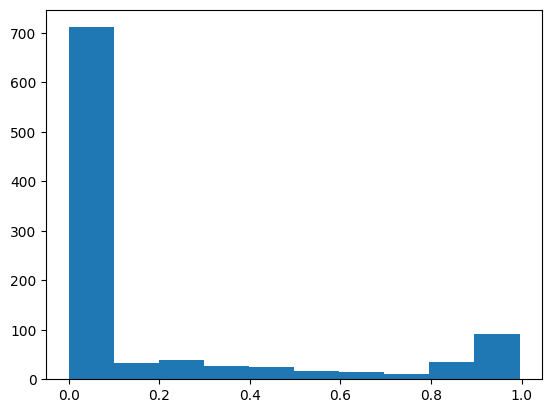

In [249]:
plt.hist(df.topic2)

In [250]:
df_topic2 = df[df.topic2 > 0.9]

In [251]:
df_topic2
# antibiotics and antifungal for skin infections, acne

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, is, an, antibiotic, that, fight, bacteria, it, is, used, to, treat, acne, which, appears, a, spot, or, pimple, on, your, face, chest, or, back, this, medicine, work, by, attacking, the, bacteria, that, cause, these, pimple, acnesol, gel, is, only, meant, for, external, use, and, should, be, used, a, advised, by, your, doctor, you, should, normally, wash, and, dry, the, affected, area, before, applying, thin, layer, of, the, medicine, it, should, not, be, applied, to, broken, or, damaged, skin, avoid, any, contact, with, your, eye, nose, or, mouth, rinse, it, off, with, water, if, you, accidentally, get, it, in, ...]",Acnesol Gel,0.0,0.000000,0.993057,0.0,"[(2, 0.99305695)]",0.0
11,"Arcolane 2% Scalp Solution belongs to a group of medicines called antifungals. It is used to treat fungal infections of the skin. It works by killing the fungus that causes infections such as athlete’s foot, thrush and ringworm.Arcolane 2% Scalp Solution should be used in the dose and duration as prescribed by your doctor. This medicine should be used regularly to get the maximum benefit from it. Do not use more than you need, it will not clear your condition faster and may only increase the side effects. Skin infections will usually get better after 2 to 4 weeks. Do not use the medicine for longer than your doctor has told you to and let him or her know if your condition does not improve after 2 to 4 weeks of treatment. If you have Athlete’s foot, wash your socks or tights thoroughly and change your shoes daily if possible.The most common side effects of using this medicine include a burning sensation and irritation, dryness, peeling, or blistering of the skin. Occasionally it can cause thinning of your hair. These are not usually serious, but you should call your doctor if you think you might have a severe allergic reaction. Signs of this include rash, swelling of the lips, throat or face, swallowing, or breathing problems. Get emergency help if this happens. Avoid direct contact with your eyes. In the case of direct contact, wash your eyes with water and seek immediate medical attention.It is not likely that other medicines you take by mouth or injection will affect the way this medicine works, but talk to your doctor before using it if you have recently used another medicine that contains a steroid or had an allergic reaction to another antifungal medicine. For pregnant or breastfeeding women, this cream should only be used if it is clearly needed.","[arcolane, scalp, solution, belongs, to, group, of, m

(array([622.,  37.,  19.,  23.,  11.,  17.,  31.,  42.,  12., 186.]),
 array([0.        , 0.0994702 , 0.1989404 , 0.29841059, 0.39788079,
        0.49735099, 0.59682119, 0.69629139, 0.79576159, 0.89523178,
        0.99470198]),
 <BarContainer object of 10 artists>)

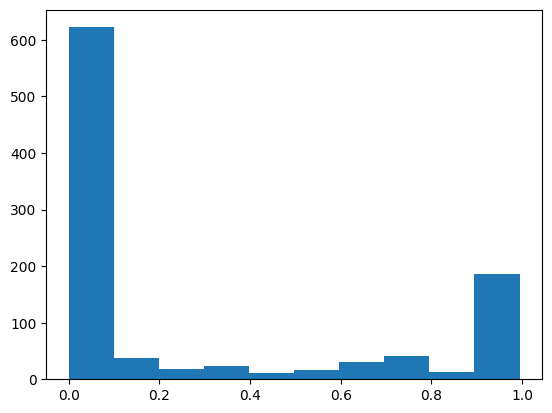

In [252]:
plt.hist(df.topic3)

In [253]:
df_topic3 = df[df.topic3 > 0.9]

In [254]:
df_topic3
# blood pressure, mental disorder drugs

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
18,"Arkamin Tablet is a medicine used in the treatment of hypertension (high blood pressure). It lowers the blood pressure by relaxing the blood vessels. Lowering the blood pressure helps to prevent future stroke and heart attack.Arkamin Tablet is also used to prevent migraine and hot flushes in women during menopause. This medicine can be taken with or without food but it is better to take it at the same time every day. You should always take this medicine as advised by the doctor and should never stop it without consulting the doctor. Most people with high blood pressure do not feel ill, but if you stop taking this medicine, your condition could get worse. This may lead to your blood pressure rising up again and increase your risk of heart disease and stroke. You should monitor your blood pressure regularly while taking this medicine.Common side effects of this medicine include dizziness, headache, nausea, fatigue, dry mouth, and constipation. Consult your doctor if these side effects bother you.Before taking this medicine, it is better to let your doctor know if you are suffering from any kidney or liver disease. Also, pregnant women and breastfeeding mothers should consult a doctor before taking it.","[arkamin, tablet, is, medicine, used, in, the, treatment, of, hypertension, high, blood, pressure, it, lower, the, blood, pressure, by, relaxing, the, blood, vessel, lowering, the, blood, pressure, help, to, prevent, future, stroke, and, heart, attack, arkamin, tablet, is, also, used, to, prevent, migraine, and, hot, flush, in, woman, during, menopause, this, medicine, can, be, taken, with, or, without, food, but, it, is, better, to, take, it, at, the, same, time, every, day, you, should, always, take, this, medicine, a, advised, by, the, doctor, and, should, never, stop, it, without, consulting, the, doctor, most, people, with, high, blood, pressure, do, not, ...]",Arkamin Tablet,0.0,0.0,0.0,0.991596,"[(3, 0.9915964)]",0.0
24,"Amlokind-AT Tablet is used to treat hypertension (high blood pressure). This is a combination of two medicines that controls blood pressure when a single medication is not effective. It helps to lower high blood pressure and thus reduces the chances of future heart attack and stroke.You can take Amlokind-AT Tablet at any time of day, on empty stomach, but it is best to take it at the same time each day. Keep taking it for as long as advised by your doctor. Even if you feel well, do not stop this medicine on your own because high blood pressure often has no symptoms. If you stop taking it, your condition may get worse. Keeping active with regular exercise, reducing your weight and eating a healthy diet will also help control your blood pressure. Follow your doctor’s advice while taking this medicine.It may cause side effects like headache, ankle swelling, slow heart rate, and nausea. It may also cause dizziness, so do not drive or do anything that requires mental focus until you know how this medicine affects you. This might raise the level of potassium in the blood, hence avoid potassium rich food or supplements. You may be asked for regular monitoring of blood pressure, kidney function, and electrolytes level while on the treatment.Before taking it, let your doctor know if you have any liver or kidney problems. Pregnant or breastfeeding women should also consult their doctor for advice before taking this medicine. You also need to tell your doctor what other medicines you are taking especially those used to treat high blood pressure or heart conditions.","[at, tablet, is, used, to, treat, hypertension, high, blood, pressure, this, is, combination, of, two, medicine, that, control, blood, pressure, when, single, medication, is, not, effective, it, help, to, lower, high, blood, pressure, and, thus, reduces, the, chance, of, future, heart, attack, and, stroke, you, can, take, at, tablet, at, any, time, of, day, on, e

(array([765.,  40.,  30.,  17.,  20.,  11.,  15.,   6.,  10.,  86.]),
 array([0.        , 0.09962113, 0.19924227, 0.2988634 , 0.39848454,
        0.49810567, 0.59772681, 0.69734794, 0.79696908, 0.89659021,
        0.99621135]),
 <BarContainer object of 10 artists>)

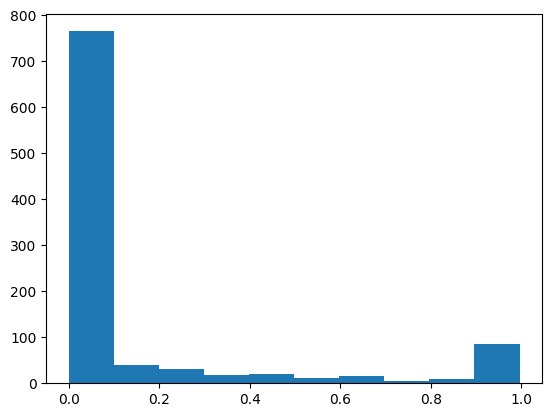

In [261]:
plt.hist(df.topic4)

In [262]:
df_topic4 = df[df.topic4 > 0.9]
df_topic4
# antibiotics, pain medication

,Introduction,tokens,medication_name,topic0,topic1,topic2,topic3,topic_estimation,topic4
2,"Augmentin 625 Duo Tablet is a penicillin-type of antibiotic that helps your body fight infections caused by bacteria. It is used to treat infections of the lungs (e.g., pneumonia), ear, nasal sinus, urinary tract, skin and soft tissue. It will not work for viral infections such as the common cold.Augmentin 625 Duo Tablet is best taken with a meal to reduce the chance of a stomach upset. You should take it regularly at evenly spaced intervals as per the schedule prescribed by your doctor. Taking it at the same time every day will help you to remember to take it. The dose will depend on what you are being treated for, but you should always complete a full course of this antibiotic as prescribed by your doctor. Do not stop taking it until you have finished, even when you feel better. If you stop taking it early, some bacteria may survive and the infection may come back or worsen.The most common side effects of this medicine include vomiting, nausea, and diarrhea. These are usually mild but let your doctor know if they bother you or will not go away.Before taking it, let your doctor know if you are allergic to any antibiotics or have any kidney or liver problems. You should also let your healthcare team know about all other medicines you are taking as they may affect, or be affected by, this medicine. This medicine is generally regarded as safe to use during pregnancy and breastfeeding if prescribed by a doctor.","[duo, tablet, is, penicillin, type, of, antibiotic, that, help, your, body, fight, infection, caused, by, bacteria, it, is, used, to, treat, infection, of, the, lung, pneumonia, ear, nasal, sinus, urinary, tract, skin, and, soft, tissue, it, will, not, work, for, viral, infection, such, a, the, common, cold, duo, tablet, is, best, taken, with, meal, to, reduce, the, chance, of, stomach, upset, you, should, take, it, regularly, at, evenly, spaced, interval, a, per, the, schedule, prescribed, by, your, doctor, taking, it, at, the, same, time, every, day, will, help, you, to, remember, to, take, it, the, dose, will, depend, on, what, ...]",Augmentin Duo Tablet,0.000000,0.0,0.0,0.0,"[(4, 0.9933866)]",0.993387
35,"Augmentin DDS Suspension is a penicillin-type of antibiotic that helps your body fight infections caused by bacteria. It is used to treat infections of the lungs (e.g., pneumonia), ear, nasal sinus, urinary tract, skin and soft tissue. It will not work for viral infections such as the common cold.Augmentin DDS Suspension is best taken with a meal to reduce the chance of a stomach upset. You should take it regularly at evenly spaced intervals as per the schedule prescribed by your doctor. Taking it at the same time every day will help you to remember to take it. The dose will depend on what you are being treated for, but you should always complete a full course of this antibiotic as prescribed by your doctor. Do not stop taking it until you have finished, even when you feel better. If you stop taking it early, some bacteria may survive and the infection may come back or worsen.The most common side effects of this medicine include vomiting, nausea, and diarrhea. These are usually mild but let your doctor know if they bother you or will not go away.Before taking it, let your doctor know if you are allergic to any antibiotics or have any kidney or liver problems. You should also let your healthcare team know about all other medicines you are taking as they may affect, or be affected by, this medicine. This medicine is generally regarded as safe to use during pregnancy and breastfeeding if prescribed by a doctor.","[dd, suspension, is, penicillin, type, of, antibiotic, that, help, your, body, fight, infection, caused, by, bacteria, it, is, used, to, treat, infection, of, the, lung, pneumonia, ear, nasal, sinus, urinary, tract, skin, and, soft, tissue, it, will, not, work, for, viral, infection, such, a, the, common, cold, dd, susp

# test codes for streamlit app

In [255]:
def get_df_each_topic(df, topic_count):

    list_df = []
    for i in range(topic_count):
        name_df = 'df_topic' + str(i)
        column = 'topic' + str(i)
        name_df = df[df[column] > 0.9]
        list_df.append(name_df)
        
    return list_df

In [258]:
list_output_df = get_df_each_topic(df, 5)

In [259]:
len(list_output_df[0])

153

In [260]:
len(list_output_df)

5

In [277]:
'. '.join(df.loc[0, 'Introduction'].split('.')[:2])

'Acnesol Gel is an antibiotic that fights bacteria.  It is used to treat acne, which appears as spots or pimples on your face, chest or back'

In [278]:
def get_first_2_sentences(text):

    first_2_sentences = '. '.join(text.split('.')[:2])

    return first_2_sentences

In [279]:
df['short_summary'] = df['Introduction'].apply(lambda x: get_first_2_sentences(x))

In [ ]:
df.head(2)